In [1]:
import cv2
import pickle as pkl
import numpy as np
from PIL import Image
import copy

import torch


## Load GT Trajectory, Past Trajectory, Drivable area

In [3]:
traj = './data_chh/train_val/traj/0c49e9b29d9c40ac8e30f5afc6d9a7aa_ea71ae526c1545119137f30ad997fbb3.traj'

road = traj.split('traj/')
road_ = road[-1].split('.')[0]
road = road[0] + 'road/' + road_ + '.jpg'

past = traj.split('traj/')
past_ = past[-1].split('.')[0]
past = past[0] + 'past/' + past_ + '.traj'

traj_ = torch.load(traj)
past_ = torch.load(past)
road_ = cv2.imread(road, cv2.IMREAD_COLOR)


## Visualize loaded data

In [4]:
TRAJ_COLORS = [(0,255,255), (255,128,0), (255,0,255), (0,0,255)]

def visualize(img_ : np.ndarray, num_modes = 1, prediction = None, gt = None, past = None, traj_slice : tuple((int, int)) = None) :
    x, y = 400, 250
    img = copy.copy(img_)

    if gt is not None:
        for gt_ in gt:
            x_cv, y_cv = int(y+gt_[0].item()*10), int(x-gt_[1].item()*10)
            cv2.drawMarker(img, (x_cv, y_cv), (0,255,0), cv2.MARKER_DIAMOND, 2, 2)

        size, _ = cv2.getTextSize('GT', cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        sx, sy = size
        cv2.rectangle(img, (x_cv,y_cv-sy-6), (x_cv+sx+6,y_cv), (255,255,255), -1)
        cv2.putText(img, 'GT', (x_cv+3,y_cv-3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)

    if past is not None:
        for past_ in past:
            x_cv, y_cv = int(y+past_[0].item()*10), int(x-past_[1].item()*10)
            cv2.drawMarker(img, (x_cv, y_cv), (255,0,0), cv2.MARKER_DIAMOND, 2,2)

    if prediction is not None:
        trajs, probs = prediction[:-num_modes], prediction[-num_modes:]
        trajs, probs = np.array_split(trajs.numpy(), num_modes, axis=0), np.array_split(probs.numpy(), num_modes, axis=0) 
    
        if traj_slice is not None:
            trajs, probs = trajs[traj_slice[0]: traj_slice[1]], probs[traj_slice[0]: traj_slice[1]] 

        for i, (traj, prob) in enumerate(zip(trajs, probs)):
            traj_x, traj_y = traj[0::2], traj[1::2]
            prob_ = prob[0]
            prev_x, prev_y = y, x
            for traj_x_, traj_y_ in zip(traj_x, traj_y):
                x_cv, y_cv = int(y+traj_x_*10), int(x-traj_y_*10)
                cv2.drawMarker(img, (x_cv, y_cv), TRAJ_COLORS[i], cv2.MARKER_CROSS, 6, 3, cv2.FILLED)
                cv2.arrowedLine(img, (prev_x, prev_y), (x_cv, y_cv), TRAJ_COLORS[i], 1, cv2.LINE_AA, tipLength=0.1)
                prev_x, prev_y = x_cv, y_cv

            prob_ = f'{prob[0]:.2f}'
            size, _ = cv2.getTextSize(prob_, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            sx, sy = size
            cv2.rectangle(img, (x_cv,y_cv-sy-6), (x_cv+sx+6,y_cv), (255,255,255), -1)
            cv2.putText(img, prob_, (x_cv+3,y_cv-3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)
    
    return img

## Generate Pseudo-GT for fake prediction (1 mode, colored in Cyan)

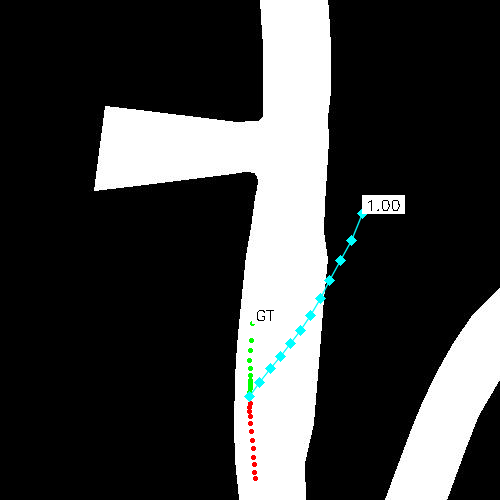

In [5]:
ps_gt = torch.tensor(list(range(len(traj_)))).unsqueeze(1)
ps_gt = torch.cat((ps_gt,ps_gt), axis=1)
ps_gt = traj_ + ps_gt
ps_gt_ = ps_gt.reshape((1,-1)).squeeze(0)
ps_gt_ = torch.cat((ps_gt_, torch.tensor([1.])), axis=0)

img1 = visualize(road_, prediction=ps_gt_, past=past_, gt=traj_)

ps_gt[-2:]
# traj_+ ps_gt
# psgt = traj_ + torch.tensor(np.arange(len(traj_)))
Image.fromarray(img1)

In [6]:
img2 = copy.copy(road_)
def world2pix(xy_w):
    x, y = 400,250
    x_p, y_p = int(y+xy_w[0].item()*10), int(x-xy_w[1].item()*10)
    return [x_p, y_p]

print(ps_gt[-5])
xy_p = world2pix(ps_gt[-5])
print(xy_p)

img2[xy_p[1], xy_p[0]]

tensor([ 7.0111, 10.1452])
[320, 298]


array([254, 254, 254], dtype=uint8)

## Define DAC metric and test with pseudo-gt

In [7]:
def dac_metric(map, prediction, num_modes = 1):

    gen_trajs = prediction
    gen_trajs = gen_trajs[:-num_modes]
    gen_trajs = gen_trajs.reshape((-1,2))
    map_array = copy.copy(map)

    da_mask = np.any(map_array > 0, axis=-1)
    decoding_timesteps = gen_trajs.shape[0]

    stay_in_da = [True for i in range(decoding_timesteps)]

    trajs = []
    for i, traj in enumerate(gen_trajs):
        trajs.append(world2pix(traj))
    trajs = np.array(trajs)

    oom_mask = np.any( np.logical_or(trajs >= 500, trajs < 0), axis=-1 )

    for t in range(decoding_timesteps):
        gen_trajs_t = trajs[t]
        oom_mask_t = oom_mask[t]
        x, y = gen_trajs_t

        if oom_mask_t:
            continue

        if not da_mask[y, x]:
            stay_in_da[t] = False

    dac_ = np.array(stay_in_da).sum() / decoding_timesteps
    return dac_

dac = dac_metric(road_, ps_gt_)
print(f'dac : {dac:.3f}')

dac : 0.667


## DAO 는 multiode path 를 생성하지 않으면 비교하는 의미가 없으므로 추가하지 않음

In [17]:
type(road_)

numpy.ndarray